In [1]:
# Importing needed libraries
import numpy as np
import pandas as pd
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error, accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split
import scipy.sparse as sp

# NLTK tools for text processing
import re, nltk
from nltk import word_tokenize
from nltk.corpus import stopwords

In [2]:
covid = pd.read_csv('covid.csv')
covid

,tweet_id,user,text,num_comments,num_retweets,num_views,timestamp
0,1245126583536562177,@CTZebra,List of American doctors and nurses who have l...,765,"2,522",0,2020-03-31T23:11:25.000Z
1,1622717043081445397,@Idlibie,The doctor in green is my cousin Abdulrahman. ...,84,846,289.1K,2023-02-06T22:01:06.000Z
2,1622733965009334275,@LauraMiers,“An estimated 622 extra deaths occurred among ...,6,77,"6,663",2023-02-06T23:08:20.000Z
3,1270844188003676161,@CTZebra,"Maria Magdaleno, 64yo nurse at a Skilled Nursi...",3,63,0,2020-06-10T22:24:00.000Z
4,1265850518435508227,@CTZebra,"Carmen Patricia “Patsy” Jones, died of #covid1...",3,12,0,2020-05-28T03:40:56.000Z
...,...,...,...,...,...,...,...
3517,1644326775592308736,@DmodosCutter,COVID caused brain damage in 2 infants infecte...,0,17,570,2023-04-07T13:10:28.000Z
3518,1644416081589674016,@RepJamesClyburn,Millions of Americans were out of work as our ...,3,36,"4,500",2023-04-07T19:05:20.000Z
3519,1644528335496552449,@DrIanWeissman,She lifted a cup of coffee to her nose and sni...,0,8,427,2023-04-08T02:31:23.000Z
3520,1644386172670492673,@Saffiya_Khan1,But the Government do nothing to protect our c...,1,16,"1,620",2023-04-07T17:06:29.000Z


In [3]:
def data_cleaning(df):
    df['user'] = df['user'].replace('[^a-zA-Z0-9]', '', regex=True)
    df['text'] = df['text'].replace('#', '', regex=True)
    df.dropna(subset=['text'], inplace=True)#3515
    df.drop_duplicates(subset=['text'], inplace=True)#3239
    return df

data_cleaning(covid)

,tweet_id,user,text,num_comments,num_retweets,num_views,timestamp
0,1245126583536562177,CTZebra,List of American doctors and nurses who have l...,765,"2,522",0,2020-03-31T23:11:25.000Z
1,1622717043081445397,Idlibie,The doctor in green is my cousin Abdulrahman. ...,84,846,289.1K,2023-02-06T22:01:06.000Z
2,1622733965009334275,LauraMiers,“An estimated 622 extra deaths occurred among ...,6,77,"6,663",2023-02-06T23:08:20.000Z
3,1270844188003676161,CTZebra,"Maria Magdaleno, 64yo nurse at a Skilled Nursi...",3,63,0,2020-06-10T22:24:00.000Z
4,1265850518435508227,CTZebra,"Carmen Patricia “Patsy” Jones, died of covid19...",3,12,0,2020-05-28T03:40:56.000Z
...,...,...,...,...,...,...,...
3517,1644326775592308736,DmodosCutter,COVID caused brain damage in 2 infants infecte...,0,17,570,2023-04-07T13:10:28.000Z
3518,1644416081589674016,RepJamesClyburn,Millions of Americans were out of work as our ...,3,36,"4,500",2023-04-07T19:05:20.000Z
3519,1644528335496552449,DrIanWeissman,She lifted a cup of coffee to her nose and sni...,0,8,427,2023-04-08T02:31:23.000Z
3520,1644386172670492673,SaffiyaKhan1,But the Government do nothing to protect our c...,1,16,"1,620",2023-04-07T17:06:29.000Z


In [4]:
def convert_value(value):
    if isinstance(value, int):
        value = str(value)
    value = value.replace(",", "")
    if value.endswith("K"):
        value = value.replace("K", "000").replace(".", "")
    elif value.endswith("M"):
        value = value.replace("M", "000000").replace(".", "")
    value = int(value)
    return value

covid['num_comments'] = covid['num_comments'].apply(convert_value)
covid['num_retweets'] = covid['num_retweets'].apply(convert_value)
covid['num_views'] = covid['num_views'].apply(convert_value)

In [5]:
def convert_timestamp(df):
    df = df[df["timestamp"] != "0"]  # Remove rows where timestamp value is "0"
    df["timestamp"] = df["timestamp"].apply(lambda x: datetime.fromisoformat(x.replace("Z", "+00:00")).strftime("%Y-%m-%d %H:%M:%S"))
    return df

covid = convert_timestamp(covid) #3238

/var/folders/vs/cm04rks963ddgl0pxtm2fgc00000gn/T/ipykernel_4490/1247661935.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["timestamp"] = df["timestamp"].apply(lambda x: datetime.fromisoformat(x.replace("Z", "+00:00")).strftime("%Y-%m-%d %H:%M:%S"))


In [6]:
covid

,tweet_id,user,text,num_comments,num_retweets,num_views,timestamp
0,1245126583536562177,CTZebra,List of American doctors and nurses who have l...,765,2522,0,2020-03-31 23:11:25
1,1622717043081445397,Idlibie,The doctor in green is my cousin Abdulrahman. ...,84,846,2891000,2023-02-06 22:01:06
2,1622733965009334275,LauraMiers,“An estimated 622 extra deaths occurred among ...,6,77,6663,2023-02-06 23:08:20
3,1270844188003676161,CTZebra,"Maria Magdaleno, 64yo nurse at a Skilled Nursi...",3,63,0,2020-06-10 22:24:00
4,1265850518435508227,CTZebra,"Carmen Patricia “Patsy” Jones, died of covid19...",3,12,0,2020-05-28 03:40:56
...,...,...,...,...,...,...,...
3517,1644326775592308736,DmodosCutter,COVID caused brain damage in 2 infants infecte...,0,17,570,2023-04-07 13:10:28
3518,1644416081589674016,RepJamesClyburn,Millions of Americans were out of work as our ...,3,36,4500,2023-04-07 19:05:20
3519,1644528335496552449,DrIanWeissman,She lifted a cup of coffee to her nose and sni...,0,8,427,2023-04-08 02:31:23
3520,1644386172670492673,SaffiyaKhan1,But the Government do nothing to protect our c...,1,16,1620,2023-04-07 17:06:29


In [7]:
tweet_text = covid['text']
tweet_text

0       List of American doctors and nurses who have l...
1       The doctor in green is my cousin Abdulrahman. ...
2       “An estimated 622 extra deaths occurred among ...
3       Maria Magdaleno, 64yo nurse at a Skilled Nursi...
4       Carmen Patricia “Patsy” Jones, died of covid19...
                              ...                        
3517    COVID caused brain damage in 2 infants infecte...
3518    Millions of Americans were out of work as our ...
3519    She lifted a cup of coffee to her nose and sni...
3520    But the Government do nothing to protect our c...
3521    What on earth is going on? Ron DeSantis recent...
Name: text, Length: 3244, dtype: object

In [8]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ziyaocui/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/ziyaocui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [9]:
 # Transforming the reviews data by removing stopwords, using regular expressions module to accept only letters,
 # tokenizing those words and then making all the words lower case for consistency.
from wordcloud import STOPWORDS
comments = []
stop_words = set(stopwords.words('english')) | set(['s','t',"https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'])

for words in tweet_text:
    only_letters = re.sub("[^a-zA-Z]", " ",words)
    tokens = nltk.word_tokenize(only_letters) #tokenize the sentences
    lower_case = [l.lower() for l in tokens] #convert all letters to lower case
    filtered_result = list(filter(lambda l: l not in stop_words, lower_case)) #Remove stopwords from the comments
    comments.append(' '.join(filtered_result))

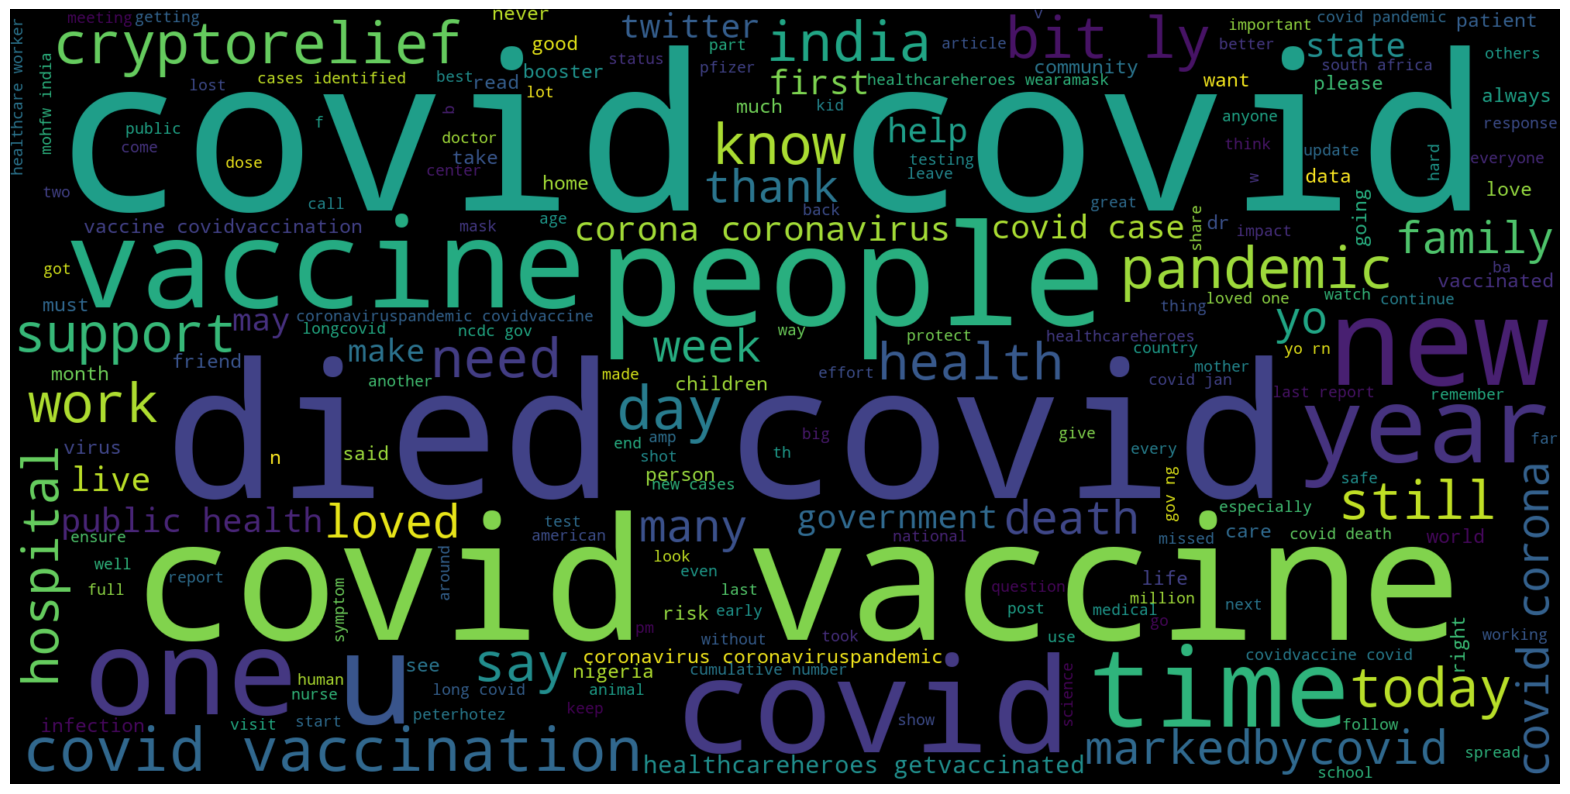

In [10]:
from wordcloud import WordCloud
from wordcloud import STOPWORDS
unique_string=(" ").join(comments)
wordcloud = WordCloud(width = 2000, height = 1000,background_color='black').generate(unique_string)
plt.figure(figsize=(20,12))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

[nltk_data] Downloading package punkt to /Users/ziyaocui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


<AxesSubplot:xlabel='Word'>

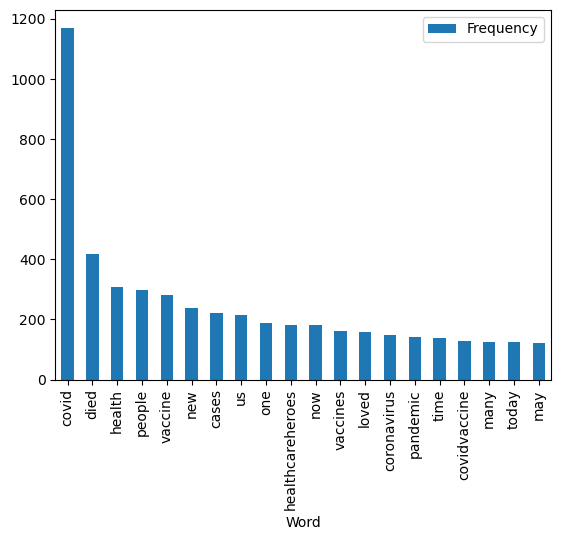

In [11]:
import nltk
nltk.download('punkt')
  
from nltk.tokenize import word_tokenize
from nltk import FreqDist

lower_full_text = tweet_text.str.lower().str.cat(sep=' ') # concatenate all strings in the series into one string
word_tokens = word_tokenize(lower_full_text)
tokens = list()
my_stop_words = ['nft','will','de','m','o','news','s','t',"https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
for word in word_tokens:
    if word.isalpha() and word not in my_stop_words:
        tokens.append(word)
token_dist = FreqDist(tokens)
dist = pd.DataFrame(token_dist.most_common(20),columns=['Word', 'Frequency'])
dist.plot.bar(x='Word',y='Frequency')


<AxesSubplot:xlabel='Stemmed Word'>

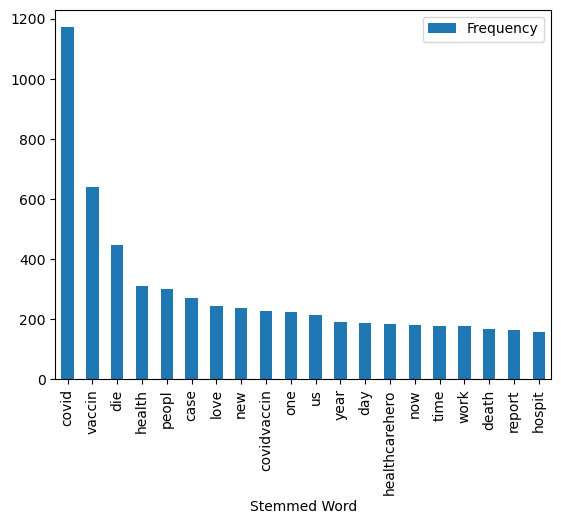

In [12]:
from nltk.stem import PorterStemmer

porter = PorterStemmer()
stemmed_tokens =[porter.stem(word) for word in tokens]
stemmed_token_dist = FreqDist(stemmed_tokens)
stemmed_dist = pd.DataFrame(stemmed_token_dist.most_common(20),columns=['Stemmed Word', 'Frequency'])
stemmed_dist.plot.bar(x='Stemmed Word',y='Frequency')

In [13]:
from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import STOPWORDS

#my_stop_words = ["https", "co", "RT", 'aren', 'couldn', 'didn', 'doesn', 'don', 'hadn', 'hasn', 'haven', 'isn', 'let', 'll', 'mustn', 're', 'rt', 'shan', 'shouldn', 've', 'wasn', 'weren', 'won', 'wouldn'] + list(STOPWORDS)
vect = CountVectorizer(stop_words=my_stop_words, ngram_range=(2,2))
bigrams = vect.fit_transform(tweet_text)
bigram_df = pd.DataFrame(bigrams.toarray(), columns=vect.get_feature_names())
bigram_frequency = pd.DataFrame(bigram_df.sum(axis=0)).reset_index()
bigram_frequency.columns = ['bigram', 'frequency']
bigram_frequency = bigram_frequency.sort_values(by='frequency', ascending=False).head(20)

/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [14]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/ziyaocui/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [15]:
sid.polarity_scores(tweet_text[10])

{'neg': 0.24, 'neu': 0.76, 'pos': 0.0, 'compound': -0.8543}

In [16]:
import pandas as pd
import seaborn as sns

sns.set(rc={'figure.figsize':(30,1)})

def visualise_sentiments(data):
  sns.heatmap(pd.DataFrame(data).set_index("Sentence").T,center=0, annot=True, cmap = "PiYG")

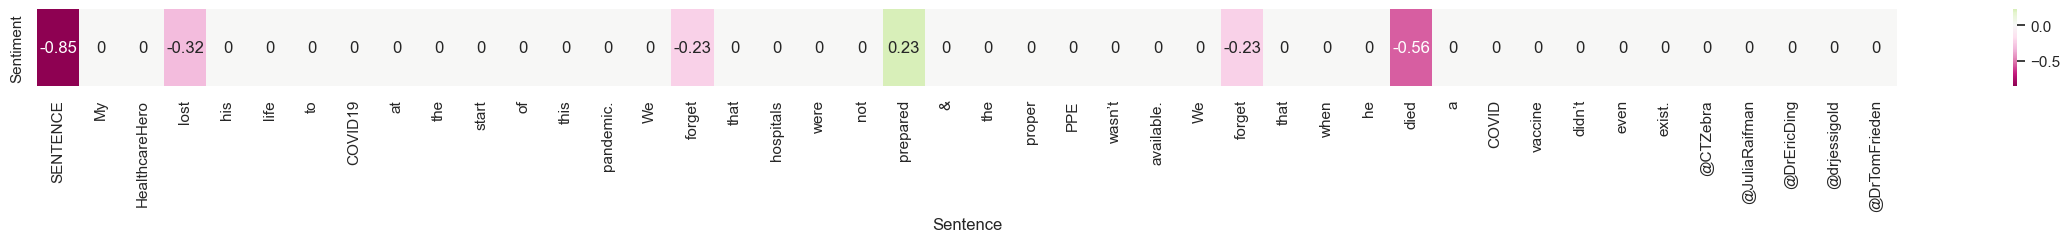

In [17]:
visualise_sentiments({
    "Sentence":["SENTENCE"] + tweet_text[10].split(),
    "Sentiment":[sid.polarity_scores(tweet_text[10])["compound"]] + [sid.polarity_scores(word)["compound"] for word in tweet_text[10].split()]
})

In [18]:
# create a new DataFrame column for compound 
covid['compound'] = tweet_text.apply(sid.polarity_scores)
covid

/var/folders/vs/cm04rks963ddgl0pxtm2fgc00000gn/T/ipykernel_4490/4113429800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid['compound'] = tweet_text.apply(sid.polarity_scores)


,tweet_id,user,text,num_comments,num_retweets,num_views,timestamp,compound
0,1245126583536562177,CTZebra,List of American doctors and nurses who have l...,765,2522,0,2020-03-31 23:11:25,"{'neg': 0.197, 'neu': 0.803, 'pos': 0.0, 'comp..."
1,1622717043081445397,Idlibie,The doctor in green is my cousin Abdulrahman. ...,84,846,2891000,2023-02-06 22:01:06,"{'neg': 0.0, 'neu': 0.89, 'pos': 0.11, 'compou..."
2,1622733965009334275,LauraMiers,“An estimated 622 extra deaths occurred among ...,6,77,6663,2023-02-06 23:08:20,"{'neg': 0.128, 'neu': 0.872, 'pos': 0.0, 'comp..."
3,1270844188003676161,CTZebra,"Maria Magdaleno, 64yo nurse at a Skilled Nursi...",3,63,0,2020-06-10 22:24:00,"{'neg': 0.107, 'neu': 0.804, 'pos': 0.089, 'co..."
4,1265850518435508227,CTZebra,"Carmen Patricia “Patsy” Jones, died of covid19...",3,12,0,2020-05-28 03:40:56,"{'neg': 0.093, 'neu': 0.907, 'pos': 0.0, 'comp..."
...,...,...,...,...,...,...,...,...
3517,1644326775592308736,DmodosCutter,COVID caused brain damage in 2 infants infecte...,0,17,570,2023-04-07 13:10:28,"{'neg': 0.368, 'neu': 0.632, 'pos': 0.0, 'comp..."
3518,1644416081589674016,RepJamesClyburn,Millions of Americans were out of work as our ...,3,36,4500,2023-04-07 19:05:20,"{'neg': 0.157, 'neu': 0.744, 'pos': 0.099, 'co..."
3519,1644528335496552449,DrIanWeissman,She lifted a cup of coffee to her nose and sni...,0,8,427,2023-04-08 02:31:23,"{'neg': 0.132, 'neu': 0.868, 'pos': 0.0, 'comp..."
3520,1644386172670492673,SaffiyaKhan1,But the Government do nothing to protect our c...,1,16,1620,2023-04-07 17:06:29,"{'neg': 0.08, 'neu': 0.865, 'pos': 0.055, 'com..."


In [19]:
#split compound column
# define lambda function to extract values
extract_values = lambda x: pd.Series([x['neg'], x['neu'], x['pos'], x['compound']], 
                                     index=['neg', 'neu', 'pos', 'compound'])

# apply lambda function to create new columns
covid[['neg', 'neu', 'pos', 'compound']] = covid['compound'].apply(extract_values)

/var/folders/vs/cm04rks963ddgl0pxtm2fgc00000gn/T/ipykernel_4490/1197180702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid[['neg', 'neu', 'pos', 'compound']] = covid['compound'].apply(extract_values)
/var/folders/vs/cm04rks963ddgl0pxtm2fgc00000gn/T/ipykernel_4490/1197180702.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid[['neg', 'neu', 'pos', 'compound']] = covid['compound'].apply(extract_values)
/var/folders/vs/cm04rks963ddgl0pxtm2fgc00000gn/T/ipykernel_4490/1197180702.py:7: SettingWith

In [20]:
import nltk
nltk.download('punkt')
from textblob import TextBlob

[nltk_data] Downloading package punkt to /Users/ziyaocui/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [21]:
# define a function that accepts text and returns the polarity
def detect_sentiment(text):
    
    #Converts the text into textblob object and then retuns
    #the polarity.
    blob = TextBlob(text)
    
    # return the polarity
    return blob.sentiment.polarity
    #return blob.sentiment.subjectivity

In [22]:
covid['sentiment'] = tweet_text.apply(detect_sentiment)

/var/folders/vs/cm04rks963ddgl0pxtm2fgc00000gn/T/ipykernel_4490/892908714.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  covid['sentiment'] = tweet_text.apply(detect_sentiment)


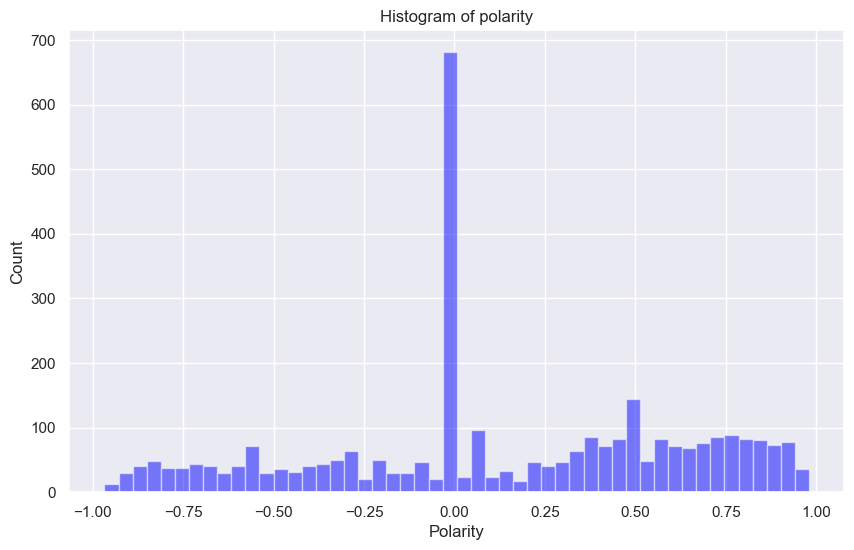

In [23]:
import numpy as np
import matplotlib.pyplot as plt
num_bins = 50
plt.figure(figsize=(10,6))
n, bins, patches = plt.hist(covid.compound, num_bins, facecolor='blue', alpha=0.5)
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Histogram of polarity')
plt.show()

/var/folders/vs/cm04rks963ddgl0pxtm2fgc00000gn/T/ipykernel_4490/3066128895.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_data['timestamp'] = pd.to_datetime(filtered_data['timestamp'])


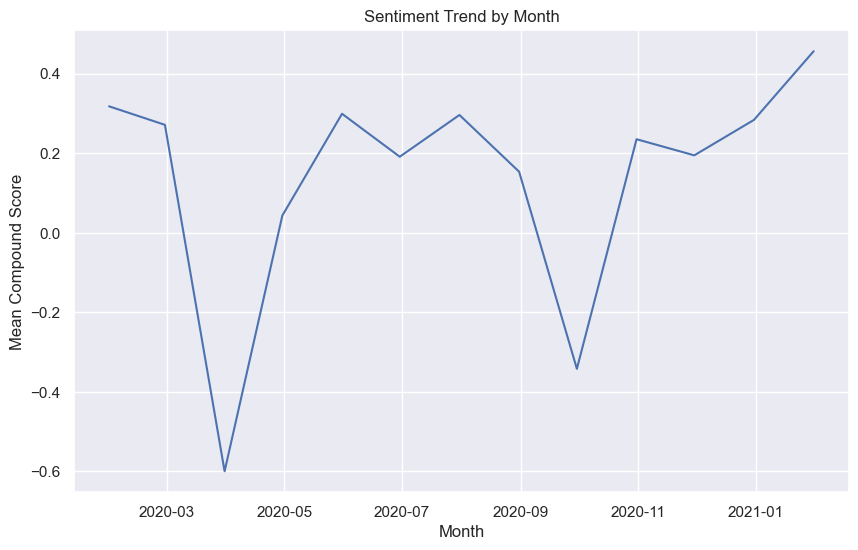

In [24]:
def plot_sentiment_trend(data, start_date, end_date):
    # Filter the data by date range
    filtered_data = data[(data['timestamp'] >= start_date) & (data['timestamp'] <= end_date)]
    # Convert timestamp column to datetime type
    filtered_data['timestamp'] = pd.to_datetime(filtered_data['timestamp'])
    # Group the data by month and calculate the mean compound score
    grouped_data = filtered_data.groupby(pd.Grouper(key='timestamp', freq='M')).mean()['compound']
    # Plot the data
    plt.figure(figsize=(10,6))
    plt.plot(grouped_data.index, grouped_data.values)
    plt.title('Sentiment Trend by Month')
    plt.xlabel('Month')
    plt.ylabel('Mean Compound Score')
    plt.show()
    
start_time = '2020-01-01 00:00:00'
end_time = '2021-01-01 23:59:59'
plot_sentiment_trend(covid, start_time, end_time)

In [25]:
df_model = covid.copy()

In [26]:
df_model['num_comments'] = df_model['num_comments'].astype(float)
df_model['num_retweets'] = df_model['num_retweets'].astype(float)
df_model['num_views'] = df_model['num_views'].astype(float)
df_model['timestamp'] = pd.to_datetime(df_model['timestamp'])


In [27]:
df_train = df_model.iloc[:, :3000]
df_test = df_model.iloc[3001:]
df_test = df_test[['text','num_comments','num_retweets','num_views']]

In [90]:
#random forest
df_rf = covid.iloc[:, :3000]

In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
import numpy as np

# Preprocess the text data
df_rf['text_tokens'] = df_rf['text'].apply(word_tokenize)
vectorizer = CountVectorizer()
X_text = vectorizer.fit_transform(df_rf['text_tokens'].apply(lambda x: ' '.join(x)))

# Combine the text features with the other features
X_rf = pd.concat([pd.DataFrame(X_text.toarray()), df_rf[['num_comments', 'num_retweets', 'num_views', 'sentiment']]], axis=1)
y_rf = df_rf['compound']

# Remove rows with missing values
X_rf = X_rf.dropna()
y_rf = y_rf.iloc[X_rf.index]

# Split the data into training and testing sets
X_rf_train, X_rf_test, y_rf_train, y_rf_test = train_test_split(X_rf, y_rf, test_size=0.5, random_state=30)

# Create a Random Forest model and fit it to the training data
rf_model = RandomForestRegressor(n_estimators=150, random_state=30)
rf_model.fit(X_rf_train, y_rf_train)

# Use the model to make predictions on the test data
y_rf_pred = rf_model.predict(X_rf_test)

# Evaluate the performance of the model
mse = mean_squared_error(y_rf_test, y_rf_pred)
print("MSE:", mse)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


MSE: 0.17875287520767416
R-squared: 0.27274562358820387


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [118]:
text_input = "According to new research people hospitalized with #COVID19 this past flu season were more to die than people hospitalized with influenza, especially if they were unvaccinated against the coronavirus."
num_comments = 100
num_retweets = 500
num_views = 50
sentiment = detect_sentiment(text_input)

# Create a dataframe with the input text and feature values
input_df = pd.DataFrame([[text_input, num_comments, num_retweets, num_views, sentiment, year, month, day, hour]], columns=['text', 'num_comments', 'num_retweets', 'num_views', 'sentiment', 'year', 'month', 'day', 'hour'])

input_df['text_tokens'] = input_df['text'].apply(word_tokenize)
X_text_input = vectorizer.transform(input_df['text_tokens'].apply(lambda x: ' '.join(x)))
X_input = pd.concat([pd.DataFrame(X_text_input.toarray()), input_df[['num_comments', 'num_retweets', 'num_views', 'sentiment']]], axis=1)
y_input_pred = rf_model.predict(X_input)

print("Predicted compound score:", y_input_pred)

Predicted compound score: [-0.45391667]


/opt/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:1688: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(
